# Imports & Configuration

In [1]:
import pandas as pd
import json

# Helper Functions

In [2]:
def split_and_label(txt, labels):
    words = txt.split()
    default_label = 'O'
    cur_word = 0
    cur_idx = 0
    out_labels = []
    for entry in labels:
        st_idx, end_idx, lbl = entry
#         print(st_idx)
        while cur_idx < st_idx:
            cur_idx += len(words[cur_word]) + 1
            cur_word += 1
            out_labels.append(default_label)
        
        while cur_idx < end_idx and cur_word < len(words):
            cur_idx += len(words[cur_word]) + 1
            cur_word += 1
            out_labels.append(lbl)
            
    while cur_word < len(words):
        out_labels.append(default_label)
        cur_word += 1
         
    assert(len(words) == len(out_labels))

    return words, out_labels

def get_labels(txt, labels):
    return split_and_label(txt, labels)[1]

def get_words(txt, labels):
    return split_and_label(txt, labels)[0]

In [3]:
def pre_process_df(df):
    df = df[~df['review'].isna()]

    df['review_no_whitespace'] = df['review'].apply(lambda r: ''.join(r.split()))

    return df

# Data Processing

In [4]:
all_df = pd.read_csv('./all_processed_data_with_citations.csv')

In [5]:
all_df.columns

Index(['title', 'decision', 'abstract', 'intro', 'conference', 'review',
       'decision_label', 'intro_len', 'abstract_len', 'review_len',
       'ce_extract', 'ce_extract_len', 'hybrid', 'hybrid_len', 'pid', 'rid',
       'uid', 'confidence_str', 'rating_str', 'paper_len', 'conclusion',
       'conclusion_len', 'url', 'emails', 'source', 'authors', 'confidence',
       'rating', 'decision_binary', 'review_no_whitespace', 'CitNum',
       'logCitNum'],
      dtype='object')

In [6]:
# Aspect Score Results
with open(f"22k_result.jsonl", encoding="utf8") as f:
    lines = f.read().splitlines()
        
asp_df = pd.DataFrame([json.loads(line) for line in lines])


In [7]:
asp_df['tokens'] = asp_df.apply(lambda row: get_words(row['text'], row['labels']), axis=1)
asp_df['tk_labels'] = asp_df.apply(lambda row: get_labels(row['text'], row['labels']), axis=1)

In [8]:
asp_df['id'] = asp_df['id'].astype(int)

In [9]:
asp_df.shape

(22921, 5)

In [12]:
all_df['id'] = all_df.index

In [13]:
asp_df = asp_df.merge(all_df, on='id')

In [ ]:
# asp_df.to_csv('all_preprocessed_data_with_citations_aspect_scores.csv', index=False)

 # Data Analysis - Construction of Aspect Score Data

In [14]:
with open('./seqlab_config.json', 'r') as infile:
    config_js = json.load(infile)

In [15]:
labels = list(config_js['label2id'].keys())

In [16]:
review = asp_df.iloc[0]['review']
tokens = asp_df.iloc[0]['tokens']
tk_labels = asp_df.iloc[0]['tk_labels']

In [17]:
asp_df['num_tokens'] = asp_df['tokens'].map(lambda t: len(t))

In [18]:
from nltk import sent_tokenize

In [19]:
from collections import defaultdict

In [23]:
def get_lbl_sent_map(tokens, tk_labels):
    st_tk_idx = 0
    cur_tk_idx = 0

    sent_labels = set()

    lbl_sent_dict = defaultdict(list)
    for i in range(len(tokens)):
        if tk_labels[i] != 'O':
            sent_labels.add(tk_labels[i])

        if tokens[i] in ['.', '?', '!']:
            for sent_lbl in sent_labels:
                lbl_sent_dict[f'{sent_lbl}_tokens'].extend(tokens[st_tk_idx:i+1])
                lbl_sent_dict[f'{sent_lbl}_tk_labels'].extend(tokens[st_tk_idx:i+1])

            sent_labels = set()
            st_tk_idx = i+1

    return lbl_sent_dict

In [24]:
entries = []

for i, row in asp_df.iterrows():
    tokens = row['tokens']
    tk_labels = row['tk_labels']
    assert(len(tokens) == len(tk_labels))
    
    entry = get_lbl_sent_map(tokens, tk_labels)
    
    entries.append(entry)

In [25]:
df = pd.DataFrame(entries)
df['id'] = df.index

In [26]:
asp_combined_df = asp_df.merge(df, on='id')

In [27]:
asp_combined_df['text_len'] = asp_combined_df['text'].apply(lambda t: len(t.split(' ')))

In [28]:
asp_combined_df['review_len'].describe()

count    22921.000000
mean       374.786353
std        246.088008
min          2.000000
25%        208.000000
50%        317.000000
75%        477.000000
max       3900.000000
Name: review_len, dtype: float64

In [29]:
asp_combined_df['text_len'].describe()

count    22921.000000
mean       427.443654
std        288.410504
min          3.000000
25%        234.000000
50%        359.000000
75%        544.000000
max       4506.000000
Name: text_len, dtype: float64

In [30]:
for lbl in labels[1:]:
    asp_combined_df[f'{lbl}_tokens'] = asp_combined_df[f'{lbl}_tokens'].apply(lambda d: d if isinstance(d, list) else [])
    asp_combined_df[f'{lbl}_review'] = asp_combined_df[f'{lbl}_tokens'].apply(lambda d: ' '.join(d))
    asp_combined_df[f'{lbl}_length'] = asp_combined_df[f'{lbl}_tokens'].apply(lambda d: len(d))
    asp_combined_df[f'{lbl}_prop'] = asp_combined_df[f'{lbl}_length'] / asp_combined_df['review_len']


In [31]:
full_text_df = pd.read_csv('./all_with_full_text.csv')

In [32]:
full_text_df['full_text_len'] = full_text_df['full_text'].apply(lambda c: len(c.split(' ')))

In [33]:
full_text_df['full_text_len'].describe()

count     7136.000000
mean      4979.109445
std       1533.148746
min        800.000000
25%       4174.750000
50%       4696.000000
75%       5368.250000
max      29151.000000
Name: full_text_len, dtype: float64

<AxesSubplot:>

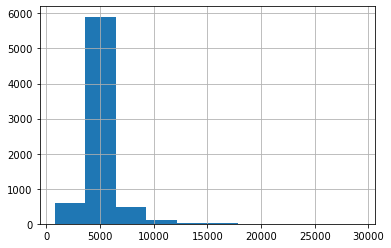

In [34]:
full_text_df['full_text_len'].hist()

In [35]:
asp_combined_df = asp_combined_df.merge(full_text_df[['title', 'full_text', 'full_text_len']].drop_duplicates('title'),
                                        on='title', 
                                        how='inner')

In [36]:
asp_combined_df['abstract_len'].describe()

count    22921.000000
mean       160.052005
std         51.237367
min         12.000000
25%        128.000000
50%        156.000000
75%        187.000000
max       1970.000000
Name: abstract_len, dtype: float64

In [37]:
asp_combined_df.to_csv('./all_pp_df_with_as_breakdowns_full_text.csv', index=False)

## Plots and Figures

In [38]:
import seaborn as sns

In [39]:
asp_combined_df[['review_len', 'full_text_len', 'rating', 'confidence']].describe().apply(lambda s: round(s))

,review_len,full_text_len,rating,confidence
count,22921.0,22921.0,12371.0,9747.0
mean,375.0,4959.0,5.0,4.0
std,246.0,1510.0,2.0,1.0
min,2.0,800.0,1.0,1.0
25%,208.0,4172.0,3.0,3.0
50%,317.0,4684.0,5.0,4.0
75%,477.0,5340.0,6.0,4.0
max,3900.0,29151.0,10.0,5.0


In [40]:
asp_combined_df[['review_len', 'full_text_len', 'rating', 'confidence', 'CitNum']].describe(
    [0.05, .25, .5, .75, 0.95]).apply(lambda s: round(s))

,review_len,full_text_len,rating,confidence,CitNum
count,22921.0,22921.0,12371.0,9747.0,20545.0
mean,375.0,4959.0,5.0,4.0,185.0
std,246.0,1510.0,2.0,1.0,1025.0
min,2.0,800.0,1.0,1.0,1.0
5%,104.0,3424.0,1.0,2.0,2.0
25%,208.0,4172.0,3.0,3.0,15.0
50%,317.0,4684.0,5.0,4.0,44.0
75%,477.0,5340.0,6.0,4.0,128.0
95%,843.0,7362.0,8.0,5.0,670.0
max,3900.0,29151.0,10.0,5.0,71907.0


<AxesSubplot:xlabel='Count', ylabel='CitNum'>

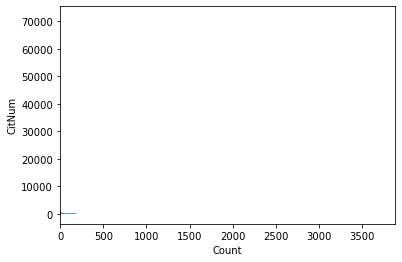

In [41]:
sns.histplot(
    data=asp_combined_df,
    y='CitNum'
)

<AxesSubplot:xlabel='Count', ylabel='logCitNum'>

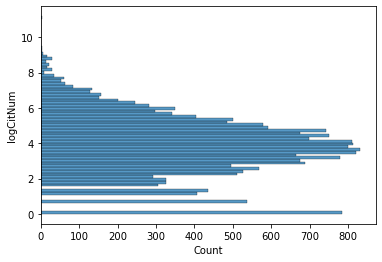

In [42]:
sns.histplot(
    data=asp_combined_df,
    y='logCitNum'
)

<AxesSubplot:>

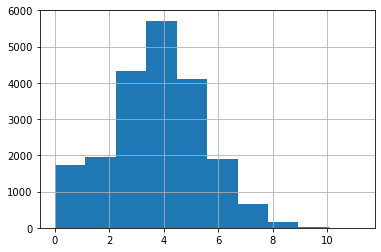

In [43]:
asp_combined_df['logCitNum'].hist()

In [44]:
import seaborn as sns

In [45]:
import matplotlib.pyplot as plt

In [48]:
# asp_combined_df[
#     (asp_combined_df['clarity_positive_length'] > 0) | (asp_combined_df['clarity_negative_length'] > 0)
# ].to_csv('clarity_preprocessed_df.csv', index=False)

In [49]:
# asp_combined_df[
#     asp_combined_df['summary_length'] > 0
# ].to_csv('summary_preprocessed_df.csv', index=False)

In [50]:
categories = {
    'originality', 'meaningful_comparison', 'replicability', 'clarity', 'substance', 'soundness', 'motivation'
}

In [52]:
import numpy as np

summary_entries = []
for cat in categories:
    filter_df = asp_combined_df[(asp_combined_df[f'{cat}_positive_length'] > 0) |
                                (asp_combined_df[f'{cat}_negative_length'] > 0)
                                ]
    
    entry = {
        'section': cat,
        'section_general': cat,
        'mean_review_proportion': np.mean(filter_df[f'{cat}_positive_prop'] + filter_df[f'{cat}_negative_prop']),
        '90th_percentile_review_proportion': (filter_df[f'{cat}_positive_prop'] + filter_df[f'{cat}_negative_prop']).quantile(0.90),
        '99th_percentile_review_proportion': (filter_df[f'{cat}_positive_prop'] + filter_df[f'{cat}_negative_prop']).quantile(0.99),
        'frequency': len(filter_df) / len(asp_combined_df),
        'mean_length': np.mean(filter_df[f'{cat}_positive_length'] + filter_df[f'{cat}_negative_length'])
    }
    
    summary_entries.append(entry)

clarity_negative
0.044584096804949826
0.14857142857142858
0.41968139193311443
0.357750534444396
clarity_positive
0.04845601403497073
0.14521452145214522
0.4538002980625904
0.4246324331399154
meaningful_comparison_negative
0.026498485371955944
0.0962566844919786
0.32274397713352376
0.23406483137733955
meaningful_comparison_positive
0.0048134077300859305
0.0
0.12963412391983786
0.05021595916408534
motivation_negative
0.011132262650057446
0.020994475138121547
0.2235628386414694
0.10601631691461978
motivation_positive
0.039032126517352925
0.1301775147928994
0.40423337856173563
0.324156886697788
originality_negative
0.03392024955816571
0.11885245901639344
0.4347459181801503
0.23991099864752846
originality_positive
0.04429680953646951
0.14189189189189189
0.44312277823352375
0.3494611927926356
replicability_negative
0.01363507906805835
0.040100250626566414
0.23852813852813814
0.13838837747044194
replicability_positive
0.0008728936889097399
0.0
0.0
0.009685441298372672
soundness_negative
0.048

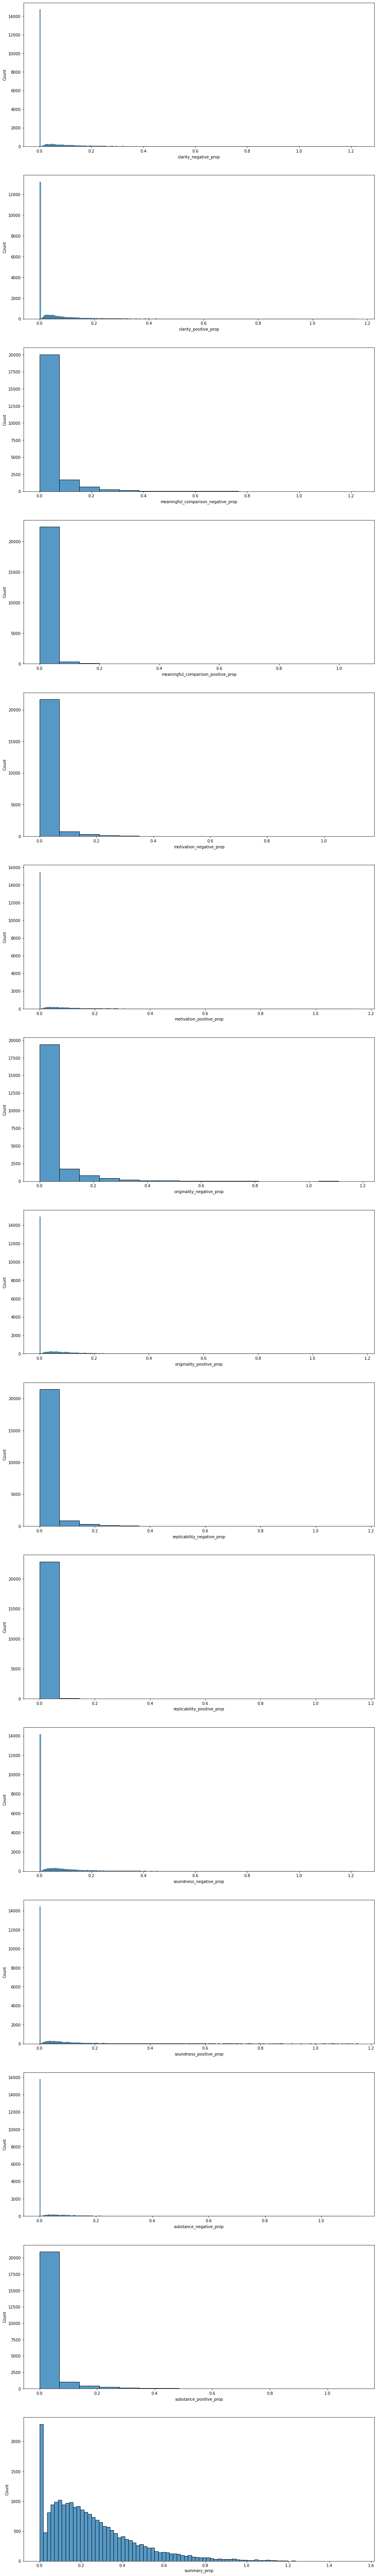

In [53]:
fig, axes = plt.subplots(len(labels[1:]), 1)

fig.set_size_inches(16, 8*len(labels[1:]))

# summary_entries = []

for i, lbl in enumerate(labels[1:]):
    print(lbl)
    entry = {
        'section': lbl,
        'section_general': lbl.split('_')[0] if '_' in lbl else lbl,
        'mean_review_proportion': asp_combined_df[asp_combined_df[f'{lbl}_length'] > 0][f'{lbl}_prop'].mean(),
        '90th_percentile_review_proportion': asp_combined_df[f'{lbl}_prop'].quantile(0.90),
        '99th_percentile_review_proportion': asp_combined_df[f'{lbl}_prop'].quantile(0.90) ,
        'frequency': len(asp_combined_df[asp_combined_df[f'{lbl}_length'] > 0]) / len(asp_combined_df),
        'mean_length': asp_combined_df[asp_combined_df[f'{lbl}_length'] > 0][f'{lbl}_length'].mean()
    }
    
    summary_entries.append(entry)
    print(asp_combined_df[f'{lbl}_prop'].mean())
    print(asp_combined_df[f'{lbl}_prop'].quantile(0.90))
    print(asp_combined_df[f'{lbl}_prop'].quantile(0.99))
    print(len(asp_combined_df[asp_combined_df[f'{lbl}_length'] > 0]) / len(asp_combined_df))
    
    sns.histplot(
        data=asp_combined_df[f'{lbl}_prop'],
        ax=axes[i]
    )

In [60]:
sum_df = pd.DataFrame(summary_entries)
sec_df = sum_df[sum_df['section'] == sum_df['section_general']].sort_values('frequency')

In [61]:
sec_df['Mean Number of Tokens in Review'] = sec_df['mean_length']

<AxesSubplot:xlabel='section', ylabel='Mean Number of Tokens in Review'>

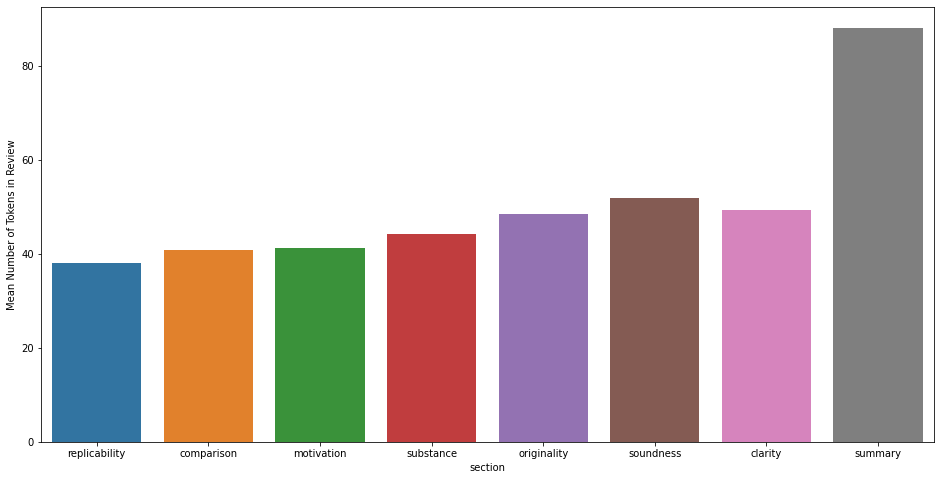

In [62]:
fig, ax = plt.subplots(1)
fig.set_size_inches(16, 8)

sns.barplot(
    data=sec_df.replace('meaningful_comparison', 'comparison'),
    x='section',
    y='Mean Number of Tokens in Review',
    ax=ax
)

In [63]:
plt.rcParams['font.size'] = 16

<AxesSubplot:xlabel='section', ylabel='frequency'>

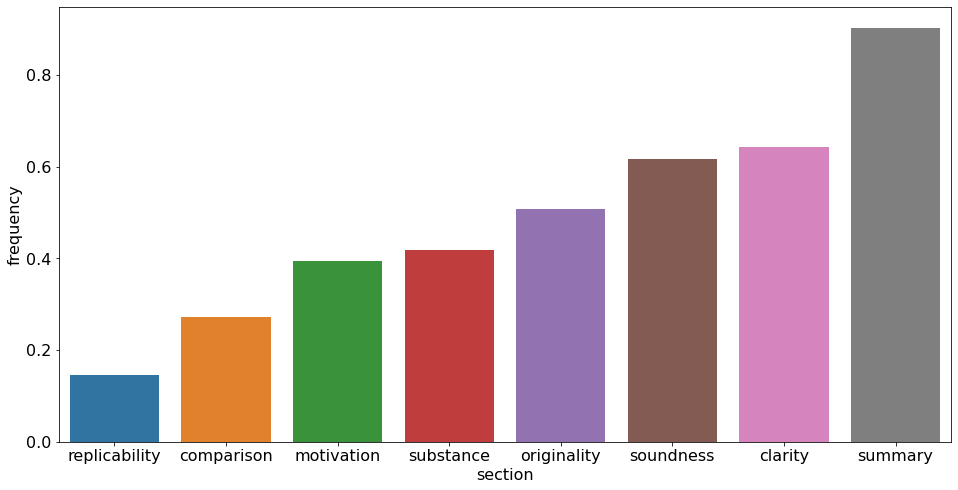

In [64]:
fig, ax = plt.subplots(1)

fig.set_size_inches(16, 8)

sns.barplot(
    data=sec_df.replace('meaningful_comparison', 'comparison'),
    x='section',
    y='frequency', 
    ax=ax
)


## Correlation Analysis

In [68]:
df = asp_combined_df.copy()

In [69]:
len(asp_combined_df[asp_combined_df['CitNum'].notna()].title.unique())

6323

In [70]:
asp_combined_df['CitNum'].describe()

count    20545.000000
mean       184.537357
std       1025.419967
min          1.000000
25%         15.000000
50%         44.000000
75%        128.000000
max      71907.000000
Name: CitNum, dtype: float64

In [71]:
length_cols = [lbl + '_length' for lbl in labels[1:]]

In [72]:
corr_df = df[['logCitNum'] + length_cols].corr()

In [73]:
corr_df = corr_df.reset_index().iloc[1:]

In [74]:
corr_df['label'] = corr_df['index'].apply(lambda s: s[:-7].replace('positive', '(+)').replace('negative', '(-)'))

In [75]:
corr_df['Correlation with log Citations'] = corr_df['logCitNum']

In [76]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='label', ylabel='Correlation with log Citations'>

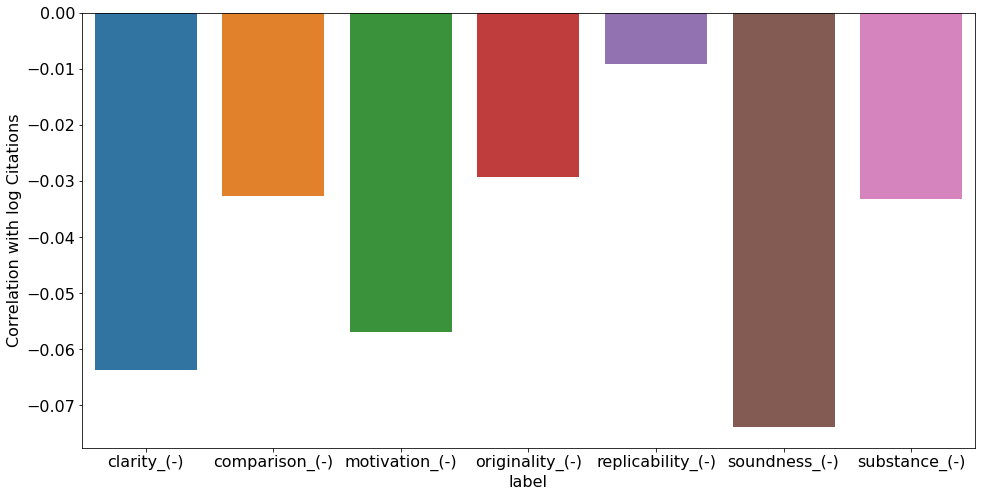

In [77]:
fig, ax = plt.subplots(1)

# ax.set_xticks(20, rotation=45)
fig.set_size_inches(16, 8)

sns.barplot(
    data=corr_df[corr_df['label'].str.contains('\-')].replace('meaningful_comparison_(-)', 'comparison_(-)'),
    x='label',
    y='Correlation with log Citations', 
    ax=ax
)

<AxesSubplot:xlabel='label', ylabel='Correlation with log Citations'>

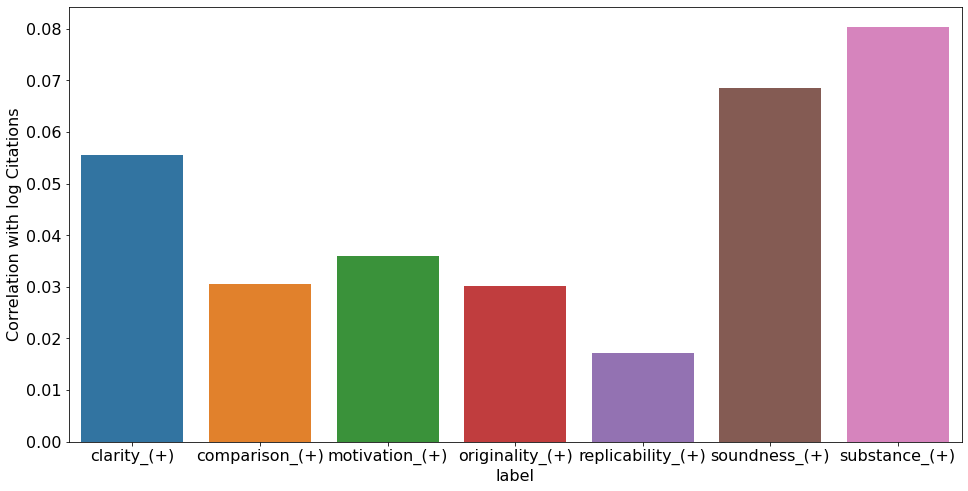

In [80]:
fig, ax = plt.subplots(1)

fig.set_size_inches(16, 8)

sns.barplot(
    data=corr_df[corr_df['label'].str.contains('\+')].replace('meaningful_comparison_(+)', 'comparison_(+)'),
    x='label',
    y='Correlation with log Citations', 
    ax=ax
)

In [81]:
print(all_df.shape)
all_df.head()

(22921, 33)


,title,decision,abstract,intro,conference,review,decision_label,intro_len,abstract_len,review_len,...,emails,source,authors,confidence,rating,decision_binary,review_no_whitespace,CitNum,logCitNum,id
0,Active Learning from Imperfect Labelers,Accept,We study active learning where the labeler can...,"In active learning, the learner is given an in...",NIPS,This article presents a method for adaptive le...,1,813,99,189,...,"yansongbai@eng.ucsd.edu, kamalika@cs.ucsd.edu,...",META,"Songbai Yan, Kamalika Chaudhuri, Tara Javidi",3.0,NaN,1.0,Thisarticlepresentsamethodforadaptivelearningi...,48.0,3.871201,0
1,Active Learning from Imperfect Labelers,Accept,We study active learning where the labeler can...,"In active learning, the learner is given an in...",NIPS,This paper studies the problem of active learn...,1,813,99,199,...,"yansongbai@eng.ucsd.edu, kamalika@cs.ucsd.edu,...",META,"Songbai Yan, Kamalika Chaudhuri, Tara Javidi",3.0,NaN,1.0,Thispaperstudiestheproblemofactivelearningunde...,48.0,3.871201,1
2,Active Learning from Imperfect Labelers,Accept,We study active learning where the labeler can...,"In active learning, the learner is given an in...",NIPS,The paper studies active learning where the la...,1,813,99,424,...,"yansongbai@eng.ucsd.edu, kamalika@cs.ucsd.edu,...",META,"Songbai Yan, Kamalika Chaudhuri, Tara Javidi",3.0,NaN,1.0,Thepaperstudiesactivelearningwherethelabelersm...,48.0,3.871201,2
3,Active Learning from Imperfect Labelers,Accept,We study active learning where the labeler can...,"In active learning, the learner is given an in...",NIPS,This paper focuses on active learning when the...,1,813,99,247,...,"yansongbai@eng.ucsd.edu, kamalika@cs.ucsd.edu,...",META,"Songbai Yan, Kamalika Chaudhuri, Tara Javidi",3.0,NaN,1.0,Thispaperfocusesonactivelearningwhenthelabeler...,48.0,3.871201,3
4,Active Learning from Imperfect Labelers,Accept,We study active learning where the labeler can...,"In active learning, the learner is given an in...",NIPS,This paper provides some theoretical analysis ...,1,813,99,153,...,"yansongbai@eng.ucsd.edu, kamalika@cs.ucsd.edu,...",META,"Songbai Yan, Kamalika Chaudhuri, Tara Javidi",1.5,NaN,1.0,Thispaperprovidessometheoreticalanalysistoacti...,48.0,3.871201,4


# Output All Reviews

In [4]:
all_citations_df = pd.read_csv('./all_processed_data_with_citations.csv')

In [8]:
all_citations_df = all_citations_df.reset_index(drop=True)

In [10]:
block_size = 5000

In [12]:
for i in range(len(all_citations_df) // block_size+1):
    output_file_path = f'./block_{i}_reviews.txt'
    st_idx, end_idx = i*block_size, min((i+1)*block_size, len(all_citations_df))
    with open(output_file_path, 'w') as outfile:
        for i, row in all_citations_df.iloc[st_idx:end_idx].iterrows():
            try:
                review = row['review']
                outfile.write(review.replace('\n', '') + '\n')
            except Exception as e:
                print(i)
                print(row['review'])

In [13]:
output_file_path = f'./all_22k_reviews.txt'
with open(output_file_path, 'w') as outfile:
    for i, row in all_citations_df.iterrows():
        try:
            review = row['review']
            outfile.write(review.replace('\n', '') + '\n')
        except Exception as e:
            print(i)
            print(row['review'])